In [1]:
!pip install -q diffusers transformers accelerate safetensors

In [ ]:
# clean up memory if needed

# import torch, gc
# gc.collect()
# if torch.cuda.is_available():
#     torch.cuda.empty_cache()

In [3]:
import os
import numpy as np
import math
from math import pi
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler
from PIL import Image
from IPython.display import display
from torchvision.transforms.functional import to_pil_image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# [Question 1] Diffusion – Toy Data (120 marks)

In [4]:
# dataset
n = 10000 # select your own number of datapoints
theta = np.linspace(0, 4*pi, n)
x = theta * np.cos(theta) * 0.1
y = theta * np.sin(theta) * 0.1

# Gaussian noise
sigma = 0.03  # choose between 0.02 to 0.05
x_noisy = x + np.random.normal(0, sigma, n)
y_noisy = y + np.random.normal(0, sigma, n)

# combine as dataset
data = np.stack([x_noisy, y_noisy], axis=1)


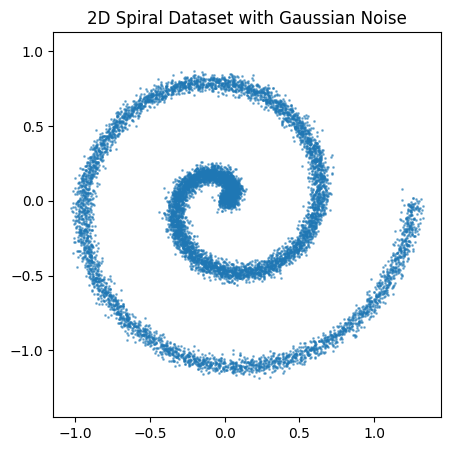

In [5]:
# visualize
plt.figure(figsize=(5,5))
plt.scatter(x_noisy, y_noisy, s=1, alpha=0.5)
plt.axis('equal')
plt.title("2D Spiral Dataset with Gaussian Noise")
plt.show()

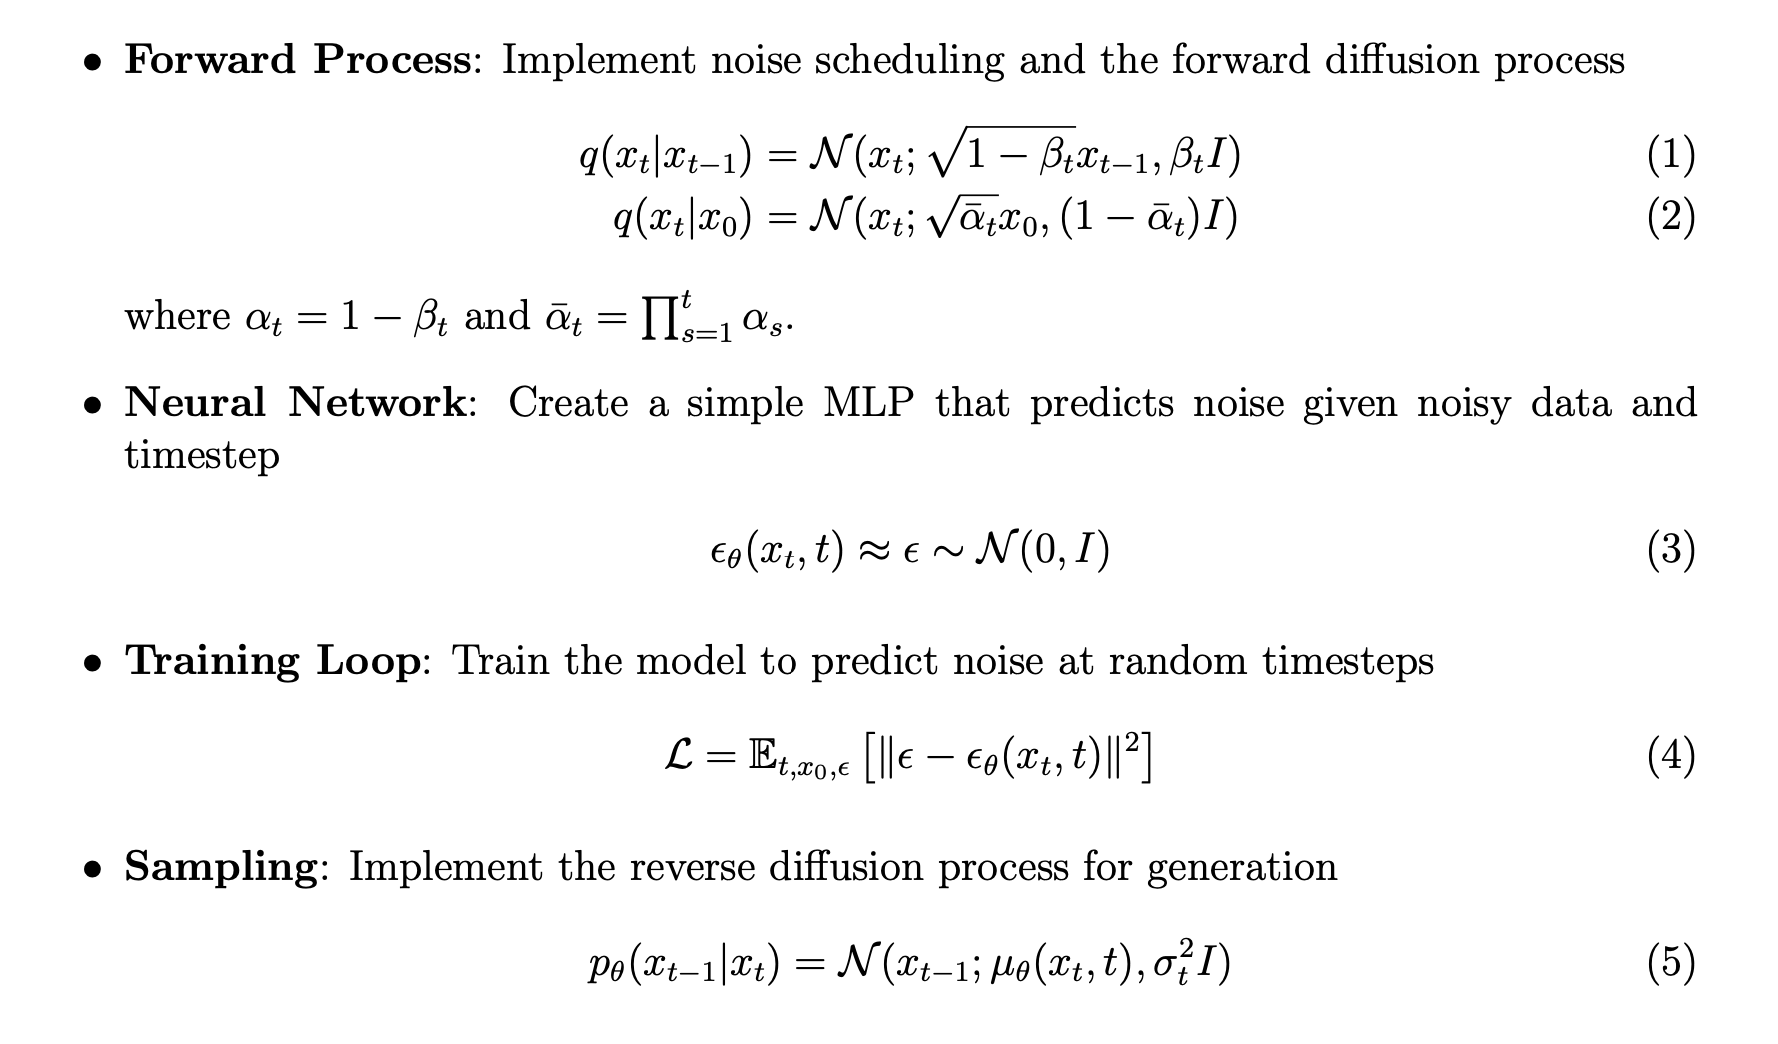

## Task I: DDPM Implementation (40 points)


In [6]:
# dataset to torch
x0 = torch.from_numpy(data).to(torch.float32).to(device)   # [B,2]
B = x0.shape[0]


# helpers
# code adapted from: https://www.youtube.com/watch?v=a4Yfz2FxXiY
# 12:24 onwards

# beta schedule (choose either linear or cosine)
def linear_beta_schedule(timesteps, start = 0.0001, end = 0.02):
  betas = torch.linspace(start, end, timesteps)
  return betas

def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = np.linspace(0, timesteps, steps)
    alphas_cumprod = np.cos(((x / timesteps) + s) / (1 + s) * pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return np.clip(betas, 0.0001, 0.9999)


def get_index_from_list(vals, t, x_shape):
    """
    returns a specific index t of a passed list of values vals
    while considering the batch dimension

    vals: [T] tensor of scalars (sqrt of alphas cumprod from 0 to T-1)
    t: [B] int64 timesteps (0 to T-1) per batch
    returns [B, 1, ...] broadcastable to x_shape
    """
    t = t.long()
    out = vals.gather(0, t)
    return out.view(-1, *([1] * (len(x_shape) - 1)))

# pre calculated buffers for closed form
T = 400  # number of diffusion steps
betas = cosine_beta_schedule(timesteps=T)
alphas = 1.0 - betas
alphas_cumprod = np.cumprod(alphas)
alphas_cumprod_prev = np.append(1.0, alphas_cumprod[:-1])
sqrt_alphas_cumprod = np.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = np.sqrt(1.0 - alphas_cumprod)
posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)

# forward closed form
def forward_diffusion_sample(x0, t, device=device):
    """
    x0: [B,2] original data
    t: [B] timesteps
    """
    # get sqrt_alphas_cumprod and sqrt_one_minus_alphas_cumprod
    sqrt_alphas_cumprod = torch.from_numpy(alphas_cumprod**0.5).to(torch.float32).to(device)
    sqrt_one_minus_alphas_cumprod = torch.from_numpy((1 - alphas_cumprod)**0.5).to(torch.float32).to(device)

    # get the coefficients for x0 and noise
    sqrt_alpha_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x0.shape)
    sqrt_one_minus_alpha_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x0.shape)

    # sample noise
    noise = torch.randn_like(x0).to(device)

    # combine them to get xt
    xt = sqrt_alpha_cumprod_t * x0 + sqrt_one_minus_alpha_cumprod_t * noise
    return xt, noise

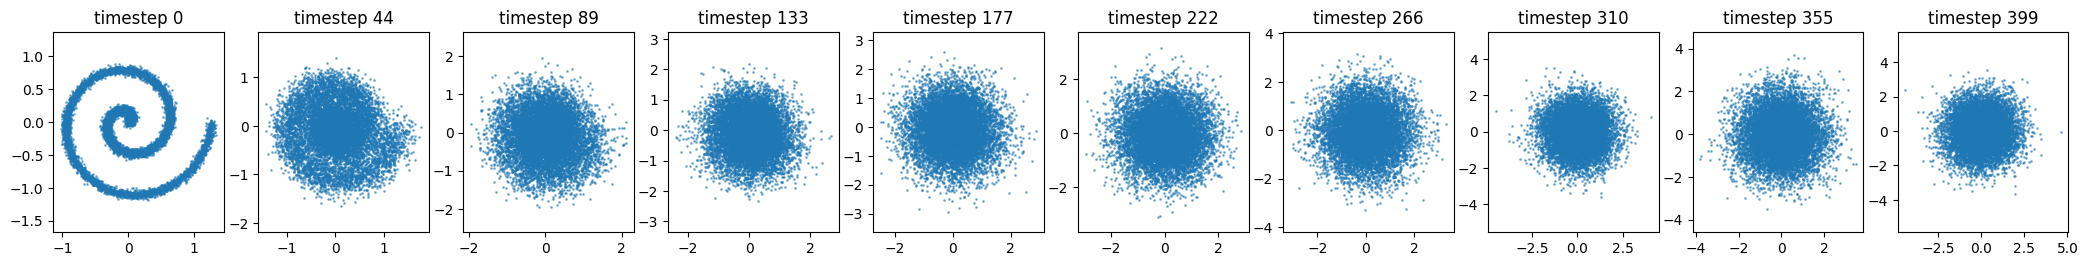

In [7]:
# simulate forward process
num_images = 10
ts = torch.linspace(0, T-1, steps=num_images, device=device).round().long()

fig, axes = plt.subplots(1, num_images, figsize=(2.6*num_images, 2.6), squeeze=True)

with torch.no_grad():
    for i in range(num_images):
        t = ts[i].repeat(B)
        xt, _ = forward_diffusion_sample(x0, t, device=device)
        xt = xt.cpu().numpy()

        axes[i].scatter(xt[:,0], xt[:,1], s=1, alpha=0.5)
        axes[i].set_title(f"timestep {ts[i].item()}")
        axes[i].axis('equal')
plt.show()

In [8]:
# time embedding
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

# simple MLP
class SimpleMLP(nn.Module):
    def __init__(self, time_dim):
        super().__init__()
        self.time_mlp = SinusoidalPositionEmbeddings(time_dim)

        self.model = nn.Sequential(
            nn.Linear(2 + time_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
        )

    def forward(self, x, t):
        t_emb = self.time_mlp(t)
        x = torch.cat([x, t_emb], dim=1)
        return self.model(x)

In [9]:
batch_size = 128
epochs = 1000
def get_or_train_simple_mlp(load_if_exists=True,
                            state_path="simple_mlp_state_dict.pth",
                            checkpoint_path="simple_mlp_checkpoint.pth",
                            time_dim=32,
                            lr=1e-3,
                            epochs=1000,
                            batch_size=128,
                            device=device,
                            T=T):
    """
    load model if exists, otherwise train a SimpleMLP, save state_dict + checkpoint, and return model + losses
    """
    model = SimpleMLP(time_dim=time_dim).to(device)

    if load_if_exists and os.path.exists(state_path):
        sd = torch.load(state_path, map_location=device)
        model.load_state_dict(sd)
        losses = []

        if os.path.exists(checkpoint_path):
            ck = torch.load(checkpoint_path, map_location=device)
            losses = ck.get("losses", [])
        print(f"Loaded model from {state_path}.")
        return model, losses

    # train
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []
    dataset = TensorDataset(x0)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model.train()
    for epoch in tqdm(range(epochs)):
        for (x0_batch,) in dataloader:
            x0_batch = x0_batch.to(device)
            t = torch.randint(0, T, (x0_batch.shape[0],), device=device).long()
            xt, noise = forward_diffusion_sample(x0_batch, t, device=device)
            noise_pred = model(xt, t)
            loss = F.mse_loss(noise_pred, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(round(loss.item(), 4))

    # save trained model (state dict) and a checkpoint with optimizer + losses
    torch.save(model.state_dict(), state_path)
    torch.save({
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "losses": losses,
        "T": T
    }, checkpoint_path)
    print(f"Saved {state_path} and {checkpoint_path}")

    return model, losses

# usage (default: try to load if exists)
model, losses = get_or_train_simple_mlp(load_if_exists=True)

100%|██████████| 1000/1000 [03:11<00:00,  5.21it/s]


Saved simple_mlp_state_dict.pth and simple_mlp_checkpoint.pth


In [10]:
# reverse process step
def reverse_diffusion_step(xt, t, model, device=device):
    """
    Takes a noisy data point at timestep t and predicts the less noisy data point at timestep t-1
    xt: [B,2] noisy data at timestep t
    t: [B] timesteps
    """
    # betas and alphas
    betas_t = torch.from_numpy(betas).to(torch.float32).to(device)
    sqrt_one_minus_alphas_cumprod_t = torch.from_numpy(sqrt_one_minus_alphas_cumprod).to(torch.float32).to(device)
    sqrt_recip_alphas_t = torch.from_numpy((1.0 / np.sqrt(alphas))).to(torch.float32).to(device)
    posterior_variance_t = torch.from_numpy(posterior_variance).to(torch.float32).to(device)

    # coefficients
    beta_t = get_index_from_list(betas_t, t, xt.shape)
    sqrt_one_minus_alpha_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod_t, t, xt.shape)
    sqrt_recip_alpha_t = get_index_from_list(sqrt_recip_alphas_t, t, xt.shape)
    posterior_variance_t = get_index_from_list(posterior_variance_t, t, xt.shape)

    # predict noise
    noise_pred = model(xt, t)

    # calculate x_{t-1}
    x0_pred = (xt - sqrt_one_minus_alpha_cumprod_t * noise_pred) / sqrt_recip_alpha_t
    mean_pred = sqrt_recip_alpha_t * (xt - beta_t * noise_pred / sqrt_one_minus_alpha_cumprod_t)

    # sample from the posterior
    noise = torch.randn_like(xt).to(device)
    nonzero_mask = (t != 0).float().view(-1, 1)  # no noise when t == 0
    xt_prev = mean_pred + nonzero_mask * torch.sqrt(posterior_variance_t) * noise
    return xt_prev


# sampling loop
num_samples = 10000
xt = torch.randn((num_samples, 2)).to(torch.float32).to(device)  # start from pure noise
for t in reversed(range(T)):
    t_batch = torch.full((num_samples,), t, device=device, dtype=torch.long)
    xt = reverse_diffusion_step(xt, t_batch, model, device=device)

# Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.
xt = xt.detach().cpu().numpy()

### DDPM - 1) scatterplot images 


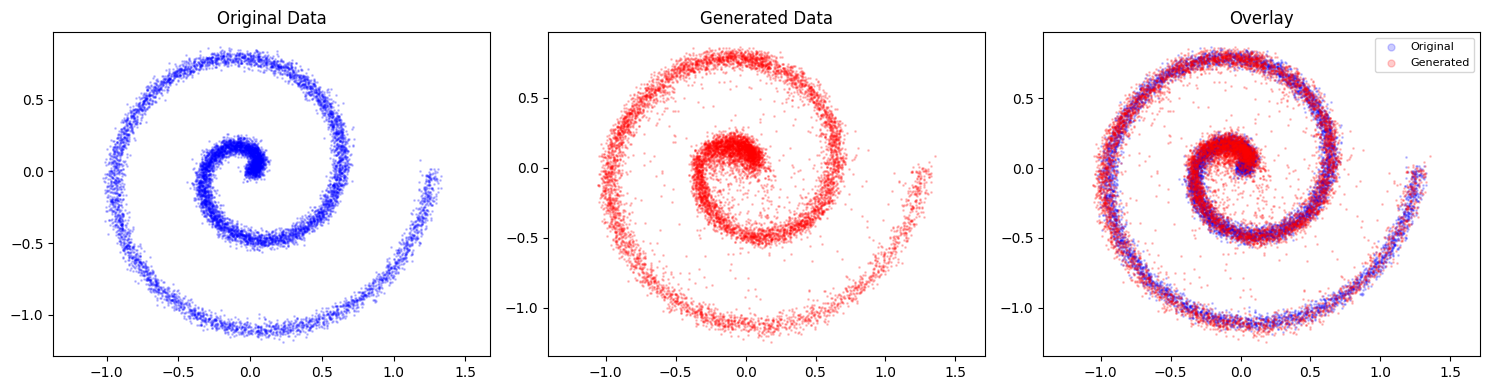

In [11]:
plt.figure(figsize=(15, 4))

# original
plt.subplot(1, 3, 1)
plt.scatter(x_noisy, y_noisy, s=1, alpha=0.2, color='blue')
plt.title("Original Data")
plt.axis('equal')

# generated
plt.subplot(1, 3, 2)
plt.scatter(xt[:,0], xt[:,1], s=1, alpha=0.2, color='red')
plt.title("Generated Data")
plt.axis('equal')

# overlay
plt.subplot(1, 3, 3)
plt.scatter(x_noisy, y_noisy, s=1, alpha=0.2, color='blue', label='Original')
plt.scatter(xt[:,0], xt[:,1], s=1, alpha=0.2, color='red', label='Generated')
plt.title("Overlay")
plt.axis('equal')
plt.legend(markerscale=5, fontsize=8)

plt.tight_layout()
plt.show()


### DDPM - 2) Training Loss Curve

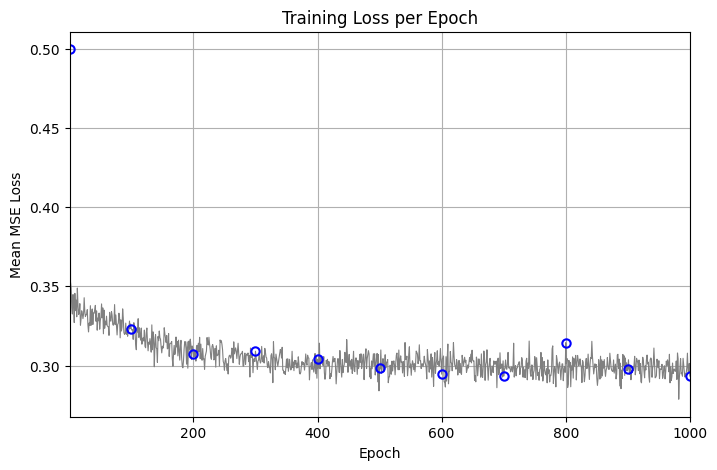

In [12]:
# aggregate batch losses into per-epoch mean losses
batches_per_epoch = math.ceil(B / batch_size) # batch_size = 128
total_updates = len(losses) # 79000
epochs_trained = total_updates / batches_per_epoch
epochs = int(round(epochs_trained))  # should be 1000
loss_arr = np.array(losses)
epoch_losses = []
for e in range(epochs):
    start = e * batches_per_epoch
    end = start + batches_per_epoch
    if start >= len(loss_arr):
        epoch_losses.append(np.nan)
    else:
        epoch_losses.append(loss_arr[start:end].mean())

# training loss curve per epoch
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), epoch_losses, linewidth=0.8, color='gray',
         marker='o', markerfacecolor='none', markeredgecolor='blue', markeredgewidth=1.5, 
         markevery=[0] + [i-1 for i in range(100, epochs+1, 100)])
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Mean MSE Loss")
plt.xlim(1, epochs)
plt.grid(True)
plt.show()

### DDPM - 3) Learned Vector Field and its Evolution Over Time

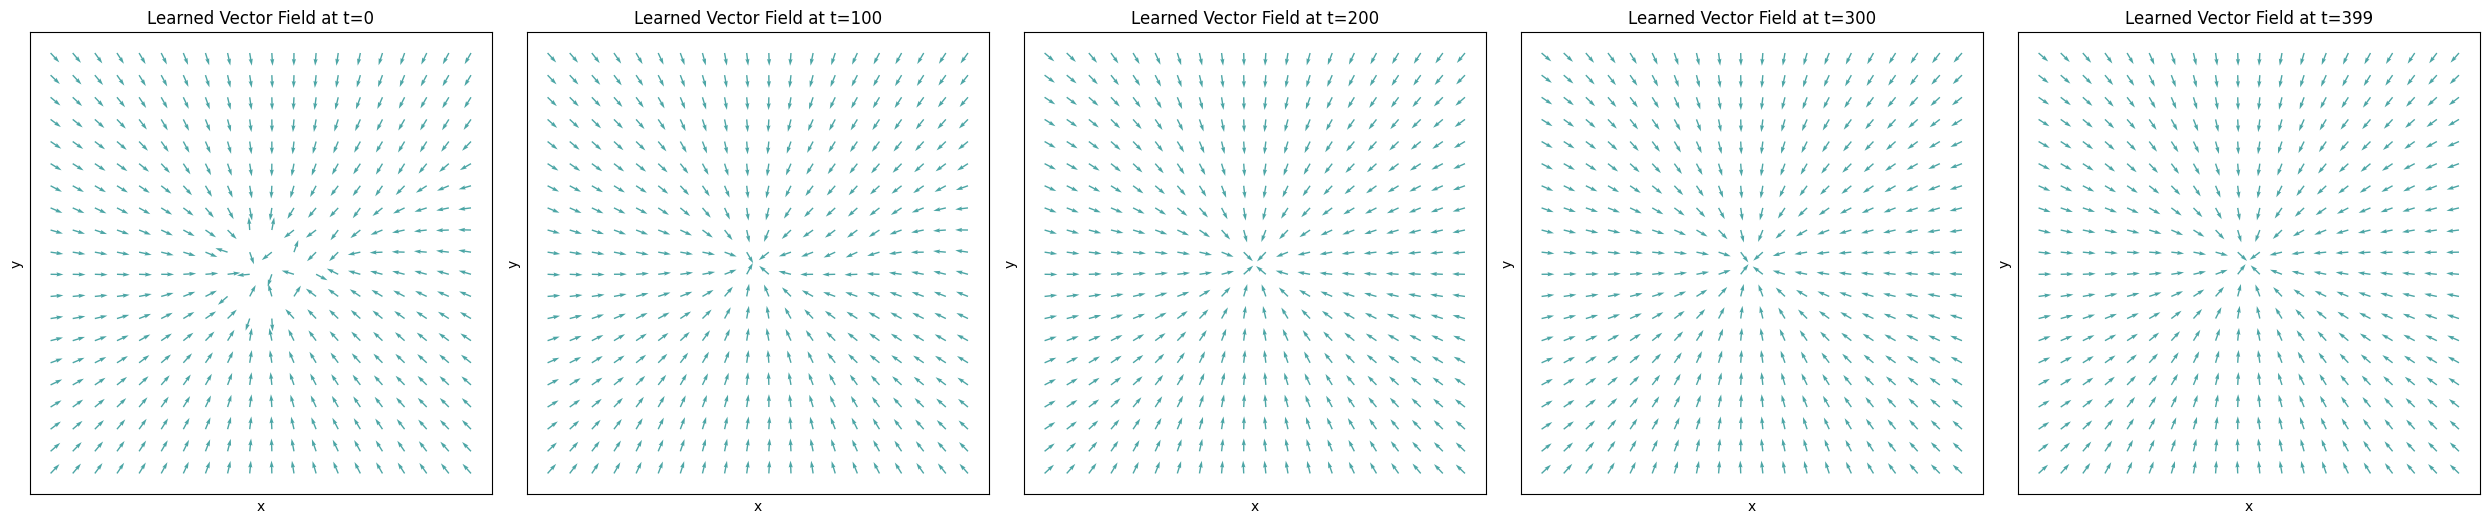

In [13]:
# visualize the learned vector field at t = [0,0.25,0.5,0.75,1.0]*T 
lvf_timesteps = [0, int(0.25*T), int(0.5*T), int(0.75*T), T-1]
fig, axes = plt.subplots(1, len(lvf_timesteps), figsize=(5*len(lvf_timesteps),5), squeeze=True)
grid_size = 20
x_vals = np.linspace(-4, 4, grid_size)
y_vals = np.linspace(-4, 4, grid_size)
X, Y = np.meshgrid(x_vals, y_vals)
points = np.stack([X.ravel(), Y.ravel()], axis=1)  # [grid_size*grid_size, 2]
points_tensor = torch.from_numpy(points).to(torch.float32).to(device)

with torch.no_grad():
    for i, t_scalar in enumerate(lvf_timesteps):
        t_batch = torch.full((points_tensor.shape[0],), t_scalar, device=device, dtype=torch.long)
        noise_pred = model(points_tensor, t_batch) # predict noise epsilon
        vector_field = -noise_pred.cpu().numpy() # negative predicted noise -> vector field
        norm = np.linalg.norm(vector_field, axis=1, keepdims=True)
        vector_field = vector_field / (norm + 1e-8) # normalize for better visualization

        U = vector_field[:,0].reshape(X.shape)
        V = vector_field[:,1].reshape(X.shape)

        ax = axes[i]
        ax.quiver(X, Y, U, V, color='teal', alpha=0.7)
        ax.set_title(f"Learned Vector Field at t={t_scalar}")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_aspect('equal', adjustable='box')
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()

## Task II: DDIM Implementation (40 points)


In [14]:
# DDIM 

# tasks: 
# 1. reverse diffusion generated with DDIM 
# 2. training loss curve 
# 3. learned vector field and its evolution over time

# task 1
def ddim_reverse_diffusion_step(xt, t, model, alphas_cumprod_t, device, ddim_eta=0.0):
    # get a_t and a_{t-1}
    alpha_cumprod_t     = get_index_from_list(alphas_cumprod_t, t,   xt.shape) # [B, 1] or [B, 2]
    alpha_cumprod_prev  = get_index_from_list(alphas_cumprod_t, t-1, xt.shape)

    # predict noise eps_θ(x_t, t)
    noise_pred = model(xt, t)

    # x0 prediction
    x0_pred = (xt - torch.sqrt(1 - alpha_cumprod_t) * noise_pred) / torch.sqrt(alpha_cumprod_t)

    # variance term for DDIM
    base_variance = ((1 - alpha_cumprod_prev) / (1 - alpha_cumprod_t)) * \
                    (1 - alpha_cumprod_t / alpha_cumprod_prev)

    sigma_t = ddim_eta * torch.sqrt(base_variance)  # [B, 1] or [B, 2]

    # direction pointing to x_t
    # (- sigma_t**2): keep total variance consistent
    dir_xt = torch.sqrt(torch.clamp(1 - alpha_cumprod_prev - sigma_t**2, min=0.0)) * noise_pred

    # sample noise
    noise = torch.randn_like(xt).to(device)

    # no extra noise when t == 0
    nonzero_mask = (t != 0).float().view(-1, 1)

    xt_prev = torch.sqrt(alpha_cumprod_prev) * x0_pred + dir_xt + nonzero_mask * sigma_t * noise
    return xt_prev


# sampling loop
num_samples = 10000
xt = torch.randn((num_samples, 2), device=device, dtype=torch.float32)

alphas_cumprod_t = torch.from_numpy(alphas_cumprod).to(device=device, dtype=torch.float32)

for t in reversed(range(1, T)):  # from T-1 down to 1; we stop before 0 to avoid t-1 = -1
    t_batch = torch.full((num_samples,), t, device=device, dtype=torch.long)
    xt = ddim_reverse_diffusion_step(
        xt, t_batch, model,
        alphas_cumprod_t=alphas_cumprod_t,
        device=device,
        ddim_eta=0.0,   # deterministic DDIM; change >0 for stochastic
    )

xt = xt.detach().cpu().numpy()

### DDIM - 1) scatterplot images 


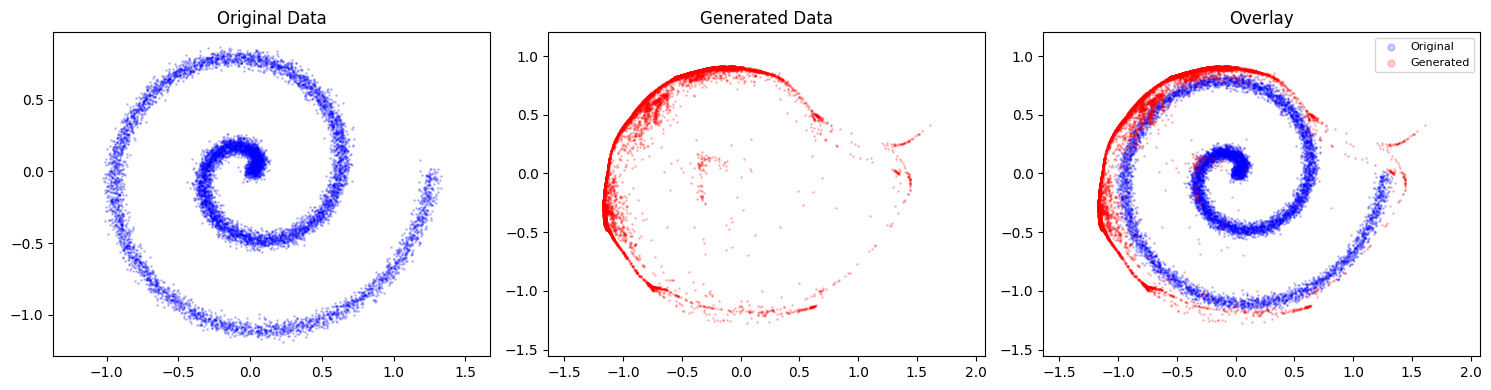

In [15]:
plt.figure(figsize=(15, 4))

# original
plt.subplot(1, 3, 1)
plt.scatter(x_noisy, y_noisy, s=1, alpha=0.2, color='blue')
plt.title("Original Data")
plt.axis('equal')

# generated
plt.subplot(1, 3, 2)
plt.scatter(xt[:,0], xt[:,1], s=1, alpha=0.2, color='red')
plt.title("Generated Data")
plt.axis('equal')

# overlay
plt.subplot(1, 3, 3)
plt.scatter(x_noisy, y_noisy, s=1, alpha=0.2, color='blue', label='Original')
plt.scatter(xt[:,0], xt[:,1], s=1, alpha=0.2, color='red', label='Generated')
plt.title("Overlay")
plt.axis('equal')
plt.legend(markerscale=5, fontsize=8)

plt.tight_layout()
plt.show()


### DDIM - 2) Training Loss Curve
- DDIM does not require a separate training process; it uses the same noise prediction (simple MLP) model as what we have done for DDPM.
- Therefore, the DDIM training loss curve is identical to the DDPM training loss curve. Please refer to the plot shown earlier.

### DDIM - 3) Learned Vector Field and its Evolution Over Time
- Since DDIM reuses the same trained model as DDPM, the underlying learned vector field is also the same. 
- What differs DDIM from DDPM is the sampling trajectory, not the learned vector field. 
- Therefore, the learned vector field visualiation for DDIM and its evolution over time is identical to those shown for DDPM. Please refer to the plot shown earlier as well. 

## Task III: Flow Matching Implementation (40 points)

In [16]:
# Flow Matching 
# task 1: a scatterplot images generated with the flow matching model
# task 2: training loss curve
# task 3: learned vector field and its evolution over time

# task 1

def get_or_train_flow_matching_model(load_if_exists=True,
                                    state_path="flow_matching_model_state_dict.pth",
                                    checkpoint_path="flow_matching_model_checkpoint.pth",
                                    time_dim=32,
                                    lr=1e-3,
                                    epochs=1000,
                                    batch_size=128,
                                    device=device,
                                    T=T):

    model = SimpleMLP(time_dim=time_dim).to(device)

    # Load existing model
    if load_if_exists and os.path.exists(state_path):
        sd = torch.load(state_path, map_location=device)
        model.load_state_dict(sd)
        losses = []

        if os.path.exists(checkpoint_path):
            ck = torch.load(checkpoint_path, map_location=device)
            losses = ck.get("losses", [])

        print(f"Loaded model from {state_path}.")
        return model, losses

    # train
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    mse = nn.MSELoss()
    losses = []

    dataset = TensorDataset(x0)          
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in tqdm(range(epochs)):
        model.train()
        total_loss = 0.0

        for (x0_batch,) in dataloader:
            x0_batch = x0_batch.to(device)
            B = x0_batch.size(0)

            # sample noise and timestep
            z = torch.randn_like(x0_batch)
            t_int = torch.randint(0, T, (B,), device=device)
            tau = t_int.float() / (T - 1)

            tau_view = tau.view(B, 1)
            x_tau = (1.0 - tau_view) * x0_batch + tau_view * z

            # true drift
            v_target = z - x0_batch

            v_pred = model(x_tau, t_int)

            loss = mse(v_pred, v_target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * B

        avg_loss = total_loss / len(dataset)
        losses.append(avg_loss)

        # save
        if (epoch+1) % 50 == 0:
            torch.save({
                "losses": losses,
                "epoch": epoch+1,
                "model_state": model.state_dict()
            }, checkpoint_path)

    torch.save(model.state_dict(), state_path)
    print(f"Saved trained flow model to {state_path}")

    return model, losses


def sample_flow_matching(model, num_samples, T, device):
    model.eval()
    xt = torch.randn((num_samples, 2), device=device, dtype=torch.float32)

    with torch.no_grad():
        for t_int in reversed(range(T)): # T-1 to 0
            t_batch = torch.full(
                (num_samples,), t_int, device=device, dtype=torch.long
            )
            # step size in continuous tau space
            dt = -1.0 / (T - 1) # from tau=1 -> 0, negative

            v = model(xt, t_batch) # v_theta(x, t_int) ≈ z - x0
            xt = xt + dt * v # euler step

    return xt.detach().cpu().numpy()


flow_matching_model, flow_matching_losses = get_or_train_flow_matching_model()

xt = sample_flow_matching(flow_matching_model, num_samples=10000, T=T, device=device)

100%|██████████| 1000/1000 [03:02<00:00,  5.47it/s]


Saved trained flow model to flow_matching_model_state_dict.pth


### Flow Matching - 1) scatterplot images 


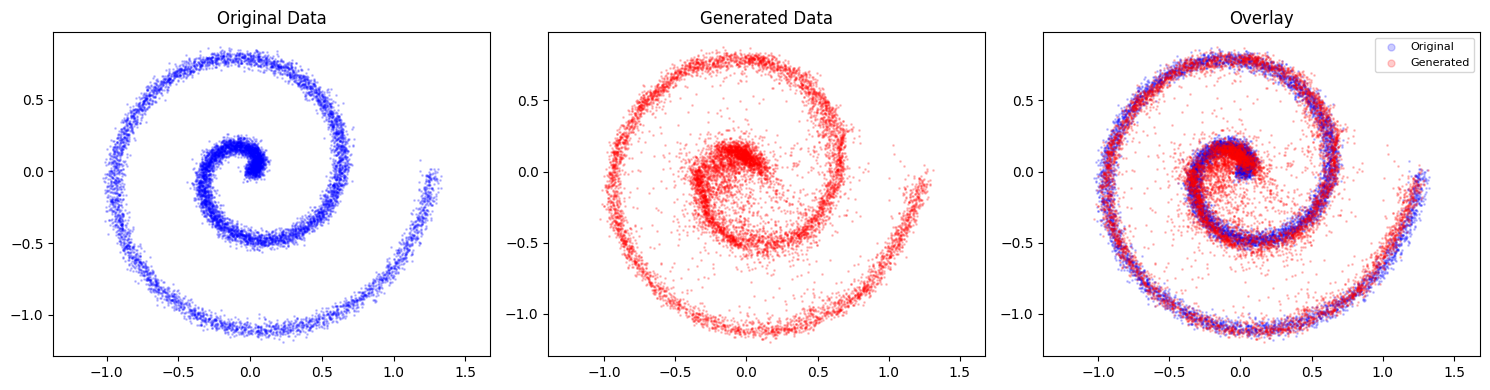

In [17]:
plt.figure(figsize=(15, 4))

# original
plt.subplot(1, 3, 1)
plt.scatter(x_noisy, y_noisy, s=1, alpha=0.2, color='blue')
plt.title("Original Data")
plt.axis('equal')

# generated
plt.subplot(1, 3, 2)
plt.scatter(xt[:,0], xt[:,1], s=1, alpha=0.2, color='red')
plt.title("Generated Data")
plt.axis('equal')

# overlay
plt.subplot(1, 3, 3)
plt.scatter(x_noisy, y_noisy, s=1, alpha=0.2, color='blue', label='Original')
plt.scatter(xt[:,0], xt[:,1], s=1, alpha=0.2, color='red', label='Generated')
plt.title("Overlay")
plt.axis('equal')
plt.legend(markerscale=5, fontsize=8)

plt.tight_layout()
plt.show()


### Flow Matching - 2) Training Loss Curve

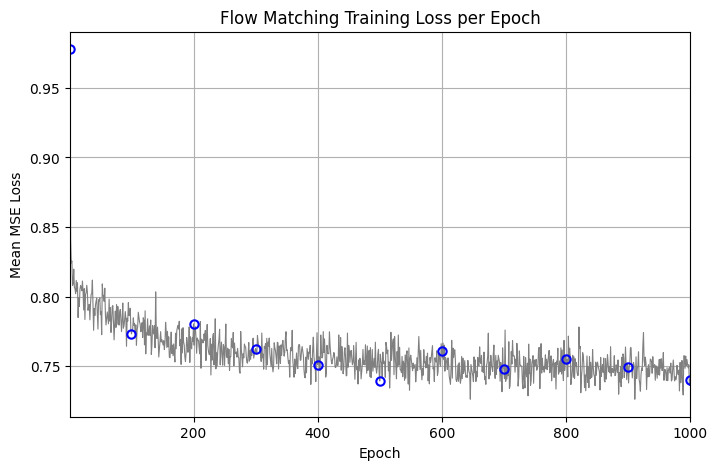

In [18]:
# task 2
# aggregate batch losses into per-epoch mean losses
epochs = len(flow_matching_losses)
loss_arr = np.array(flow_matching_losses)
epoch_losses = []
for e in range(epochs):
    epoch_losses.append(loss_arr[e])
# training loss curve (per-epoch)
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), epoch_losses, linewidth=0.8, color='gray',
         marker='o', markerfacecolor='none', markeredgecolor='blue', markeredgewidth=1.5, 
         markevery=[0] + [i-1 for i in range(100, epochs+1, 100)])
plt.title("Flow Matching Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Mean MSE Loss")
plt.xlim(1, epochs)
plt.grid(True)
plt.show()

### Flow Matching - 3) Learned Vector Field and its Evolution Over Time

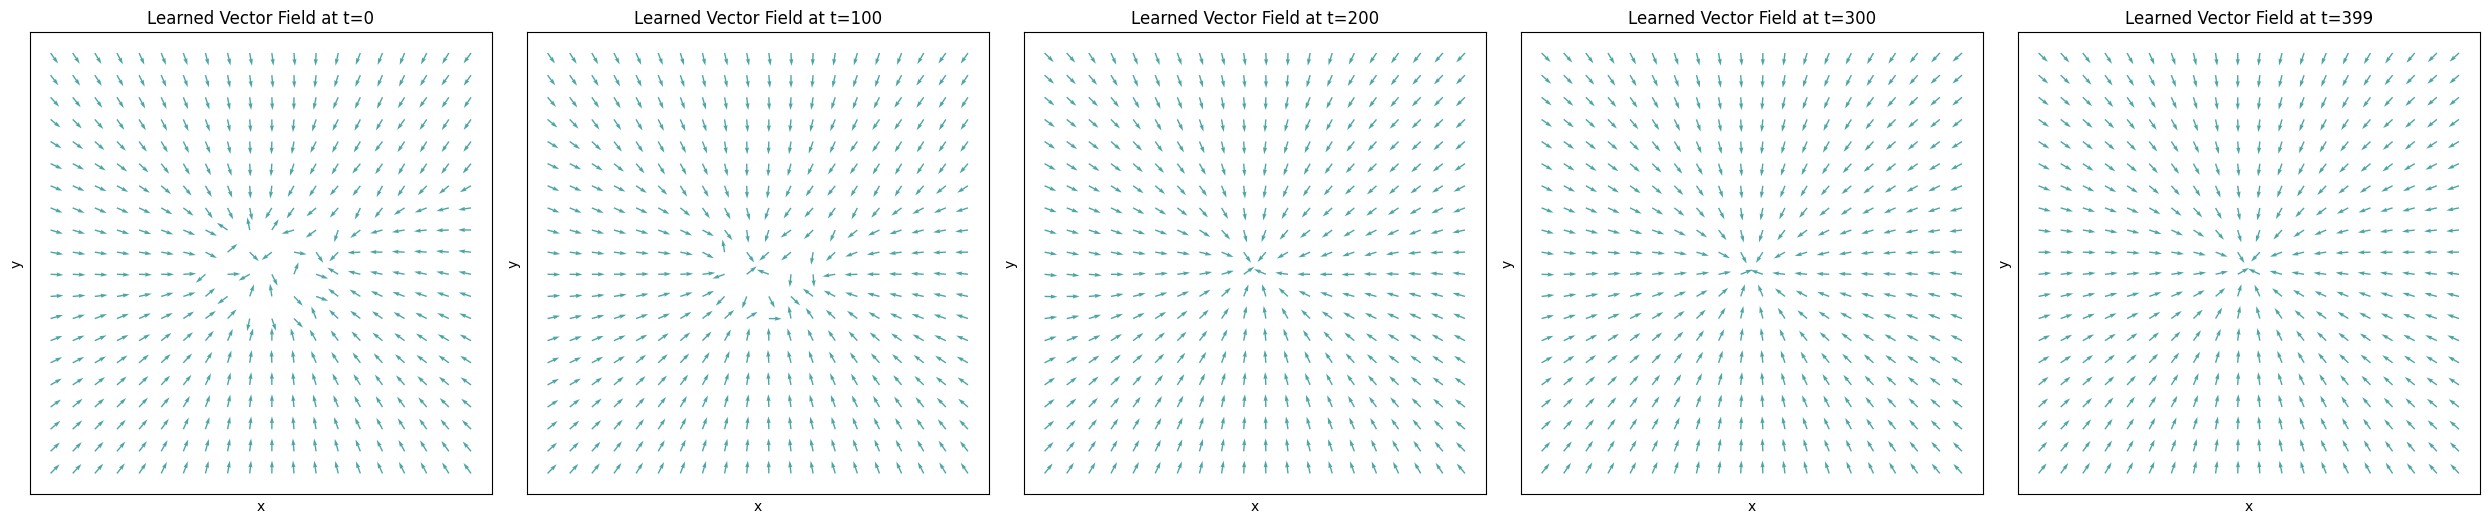

In [19]:
# task 3 
# visualize the learned vector field at t = [0,0.25,0.5,0.75,1.0]*T 
lvf_timesteps = [0, int(0.25*T), int(0.5*T), int(0.75*T), T-1]
fig, axes = plt.subplots(1, len(lvf_timesteps), figsize=(5*len(lvf_timesteps),5), squeeze=True)
grid_size = 20
x_vals = np.linspace(-4, 4, grid_size)
y_vals = np.linspace(-4, 4, grid_size)
X, Y = np.meshgrid(x_vals, y_vals)
points = np.stack([X.ravel(), Y.ravel()], axis=1)  #[grid_size*grid_size, 2]
points_tensor = torch.from_numpy(points).to(torch.float32).to(device)   
with torch.no_grad():
    for i, t_scalar in enumerate(lvf_timesteps):
        t_batch = torch.full((points_tensor.shape[0],), t_scalar, device=device, dtype=torch.long)
        noise_pred = flow_matching_model(points_tensor, t_batch)         # predict noise epsilon
        vector_field = -noise_pred.cpu().numpy()          # negative predicted noise -> vector field
        norm = np.linalg.norm(vector_field, axis=1, keepdims=True)
        vector_field = vector_field / (norm + 1e-8)   # normalize for better visualization

        U = vector_field[:,0].reshape(X.shape)
        V = vector_field[:,1].reshape(X.shape)

        ax = axes[i]
        ax.quiver(X, Y, U, V, color='teal', alpha=0.7)
        ax.set_title(f"Learned Vector Field at t={t_scalar}")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_aspect('equal', adjustable='box')
        ax.set_xticks([])
        ax.set_yticks([])
plt.tight_layout()
plt.show()

---
# [Question 2] Diffusion – vertical flip (80 marks)

### four prompt pairs:
1. a duck / a rabbit 
2. a cartoon boat / a cartoon fish 
3. forested mountains / a crocodile 
4. a penguin / a giraffe (inspired by this paper: [https://dangeng.github.io/visual_anagrams/](https://dangeng.github.io/visual_anagrams/))

In [20]:
# model and pipe 
model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16 if device == "cuda" else torch.float32,
)
pipe = pipe.to(device)
pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)
pipe.enable_attention_slicing()
pipe.enable_vae_slicing()
pipe.enable_vae_tiling()


# helpers

def flip_vertical(x):
    # x: [B, C, H, W] or [C, H, W] 
    return torch.flip(x, dims=[-2])  # -2 is height, same as dims=[2] for [B,C,H,W]

def flip_latents(latents):
    return torch.flip(latents, dims=[2])  # vertical flip


def encode_prompt(prompt: str):
    # tokenize
    text_inputs = pipe.tokenizer(
        prompt,
        padding="max_length",
        max_length=pipe.tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )

    # encode with CLIP text encoder 
    text_embeddings = pipe.text_encoder(
        input_ids=text_inputs.input_ids.to(device),
        attention_mask=text_inputs.attention_mask.to(device),
    )[0]  # [1, seq_len, hidden_dim]

    text_embeddings = text_embeddings.to(device=device, dtype=pipe.unet.dtype)
    return text_embeddings


def get_text_embeddings(prompt, negative_prompt="", batch_size=1):
    # Uses pipeline's internal helper (works in diffusers >=0.15 ish)
    return pipe._encode_prompt(
        prompt=prompt,
        device=device,
        num_images_per_prompt=batch_size,
        do_classifier_free_guidance=True,
        negative_prompt=negative_prompt,
    )


@torch.no_grad()
def generate_vertical_anagram(prompt1, prompt2,
                              num_inference_steps=50,
                              guidance_scale=7.5,
                              height=512, width=512):
    pipe.scheduler.set_timesteps(num_inference_steps, device=device)

    # sample initial noise in latent space
    latents = torch.randn(
        (1, pipe.unet.config.in_channels, height // 8, width // 8),
        device=device,
        dtype=pipe.unet.dtype,
    ) * pipe.scheduler.init_noise_sigma

    # text embeddings (manual CFG)
    emb_uncond = encode_prompt("")
    emb_1 = encode_prompt(prompt1) 
    emb_2 = encode_prompt(prompt2) 

    # senoising loop
    for t in pipe.scheduler.timesteps:

        # prompt 1 path (no flip)
        latents_scaled = pipe.scheduler.scale_model_input(latents, t)

        noise_uncond_1 = pipe.unet(
            latents_scaled,
            t,
            encoder_hidden_states=emb_uncond,
        ).sample

        noise_text_1 = pipe.unet(
            latents_scaled,
            t,
            encoder_hidden_states=emb_1,
        ).sample

        eps_1 = noise_uncond_1 + guidance_scale * (noise_text_1 - noise_uncond_1)

        # prompt 2 path (with vertical flip)
        latents_flip = flip_latents(latents)
        latents_flip_scaled = pipe.scheduler.scale_model_input(latents_flip, t)

        noise_uncond_2 = pipe.unet(
            latents_flip_scaled,
            t,
            encoder_hidden_states=emb_uncond,
        ).sample

        noise_text_2 = pipe.unet(
            latents_flip_scaled,
            t,
            encoder_hidden_states=emb_2,
        ).sample

        eps_2 = noise_uncond_2 + guidance_scale * (noise_text_2 - noise_uncond_2)

        # flip noise back so it aligns with original orientation
        eps_2_unflipped = flip_latents(eps_2)

        # combine both noise fields
        eps = 0.5 * (eps_1 + eps_2_unflipped)

        # scheduler step with the averaged noise
        latents = pipe.scheduler.step(eps, t, latents).prev_sample

    # decode latents → image
    image = pipe.vae.decode(latents / 0.18215).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    return image  # [1, 3, H, W]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


In [21]:
# four pairs in the same subplot
# 1. a duck / a rabbit 
# 2. a cartoon boat / a cartoon fish 
# 3. forested mountains / a crocodile 
# 4. a penguin / a giraffe 

img_tensor_1 = generate_vertical_anagram("a duck", "a rabbit")[0]
img_pil_1 = to_pil_image(img_tensor_1)
img_tensor_2 = generate_vertical_anagram("a cartoon boat", "a cartoon fish")[0]
img_pil_2 = to_pil_image(img_tensor_2)
img_tensor_3 = generate_vertical_anagram("forested mountains", "a crocodile")[0]
img_pil_3 = to_pil_image(img_tensor_3)
img_tensor_4 = generate_vertical_anagram("a penguin", "a giraffe")[0]
img_pil_4 = to_pil_image(img_tensor_4)

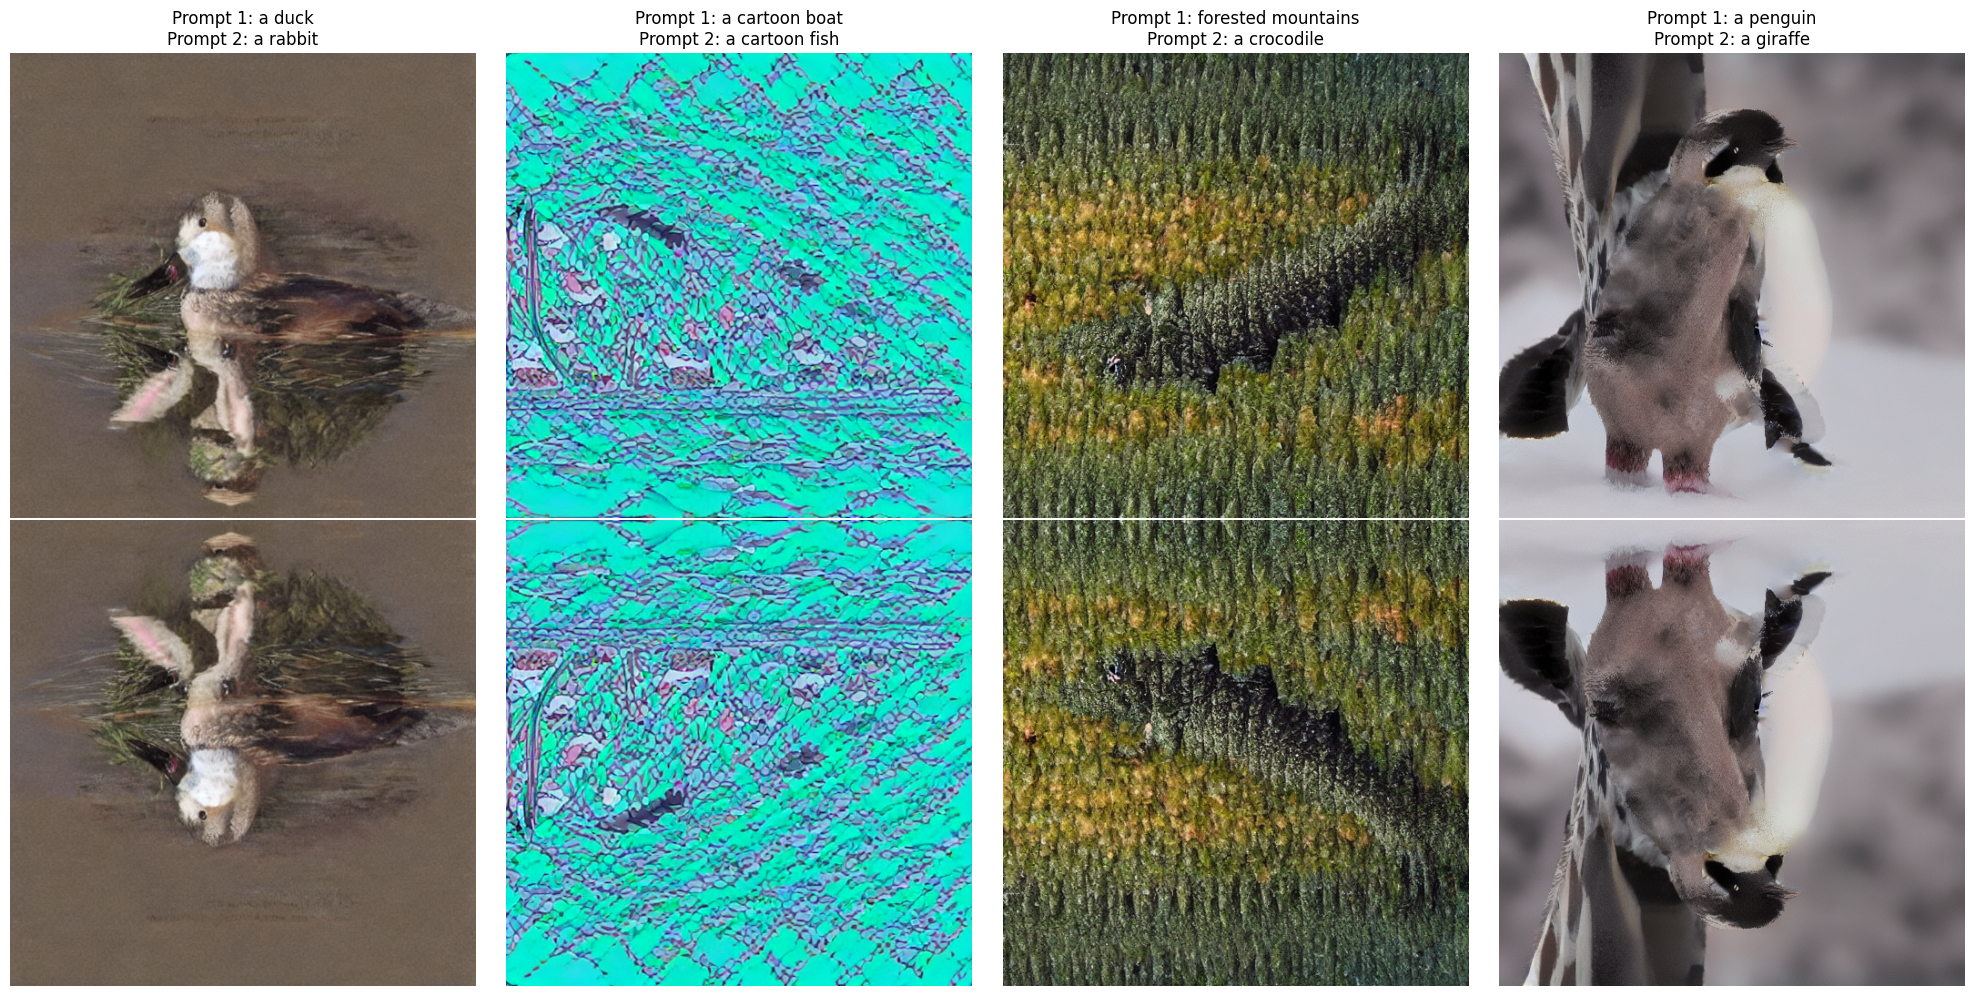

In [22]:
# display

imgs = [img_pil_1, img_pil_2, img_pil_3, img_pil_4]
titles = [
    "Prompt 1: a duck\nPrompt 2: a rabbit",
    "Prompt 1: a cartoon boat\nPrompt 2: a cartoon fish",
    "Prompt 1: forested mountains\nPrompt 2: a crocodile",
    "Prompt 1: a penguin\nPrompt 2: a giraffe"
]

fig, axes = plt.subplots(2, 4, figsize=(20,10))

for i in range(4):
    axes[0, i].imshow(np.array(imgs[i]))
    axes[0, i].set_title(titles[i])
    axes[0, i].axis("off")

for i in range(4):
    flipped = imgs[i].transpose(Image.FLIP_TOP_BOTTOM)
    axes[1, i].imshow(np.array(flipped))
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# clean up memory if needed

import torch, gc

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()